In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

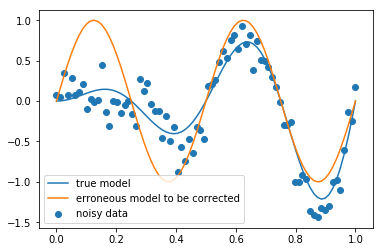

In [2]:
gridsize = 80
xs = np.linspace(0, 1, gridsize)

ymod = np.sin(xs*np.pi*4)
ymod_truth = np.sin(xs*np.pi*4) * np.tan(xs)
yvar = np.repeat(0.2**2, gridsize)
ys = ymod_truth + np.random.randn(gridsize)*yvar**0.5

plt.scatter(xs, ys, label='noisy data')
plt.plot(xs, ymod_truth, label='true model')
plt.plot(xs, ymod, label='erroneous model to be corrected')
plt.legend()

In [3]:
max_correction_magnitude = 1.0

Model_grid = tf.placeholder(shape=[gridsize, ], dtype=tf.float32)
Corrections_unbounded = tf.Variable(np.random.randn(gridsize, ), dtype=tf.float32)
Dim_grid = tf.placeholder(shape=[gridsize, ], dtype=tf.float32)

# We need to set the lengthscale/smoothness of the GP in the two dimensions.
# Those are positive (thus the exponentiation) and will be optimized.
GPlengthscale = tf.exp(tf.Variable(-1, dtype=tf.float32, trainable=True))

# The (cholesky decompositions) of the covariance matrices
Diagnoise = tf.diag(tf.cast(tf.constant(np.repeat(1e-5, gridsize)), dtype=tf.float32))
Covariance = tf.exp(-0.5*((Dim_grid[:, None] - Dim_grid[None, :])/GPlengthscale)**2.0) + Diagnoise
CovarianceChol = tf.cholesky(Covariance)

LogDet = tf.linalg.logdet(Covariance) # scalar
# Size: num_bands x numtypes
LogGPprior = -0.5*tf.reduce_sum(Corrections_unbounded[:, None] * tf.cholesky_solve(CovarianceChol, Corrections_unbounded[:, None])) - 0.5*LogDet

Corrections = max_correction_magnitude * (2*tf.sigmoid(Corrections_unbounded) - 1)
 
Corrected_model_grid = Model_grid + Corrections

Obs = tf.placeholder(shape=[None, ], dtype=tf.float32)
Obs_var = tf.placeholder(shape=[None, ], dtype=tf.float32)

Chi2s = tf.reduce_sum((Obs - Corrected_model_grid)**2/Obs_var)
Loglikes = - 0.5 * Chi2s - 0.5 * tf.reduce_sum(Obs_var)

Nu = tf.Variable(100.0, dtype=tf.float32, trainable=True)
Nud2 = (Nu + 1.0)/2.0
Loglikes_studentt = tf.lgamma(Nud2) - tf.lgamma(Nu/2.0) - 1.0/2.0 * tf.log(Nu) \
    - 0.5 * tf.reduce_sum(Obs_var) - Nud2 *tf.log(1 + Chi2s / Nu)

MinusLogprob = - Loglikes - LogGPprior
MinusLogprob_noGP = - Loglikes

a = 1.2; nu0 = 0.55
#LnNuPrior = a*tf.log( (Nu/nu0)**(0.5/a) + (Nu/nu0)**(2.0/a) )
alpha = 2.0; beta = 0.1
LnNuPrior = alpha*tf.log(beta) + (alpha-1)*tf.log(Nu) - beta*Nu - tf.lgamma(alpha)

MinusLogprob_studentt = - Loglikes_studentt - LogGPprior - LnNuPrior


In [4]:
num_iterations = 50000
learning_rate = 1e-2

Optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)\
    .minimize(MinusLogprob)

Optimizer_studentt = tf.train.AdamOptimizer(learning_rate=learning_rate)\
    .minimize(MinusLogprob_studentt)
    
Optimizer_noGP = tf.train.AdamOptimizer(learning_rate=learning_rate)\
    .minimize(MinusLogprob_noGP)
    
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_iterations):        
        _, minuslogprob, corrections, gplengthscale =\
           sess.run([Optimizer, MinusLogprob, Corrections, GPlengthscale],
                     feed_dict={Model_grid: ymod, Obs: ys, Obs_var: yvar, Dim_grid: xs}) 
        if i % 2000 == 0:
            print('Iteration', i, ': gp lengthscale = ', gplengthscale, 'minuslogprob = ', minuslogprob)
            
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_iterations):
        _, minuslogprob_noGP, corrections_noGP =\
           sess.run([Optimizer_noGP, MinusLogprob_noGP, Corrections],
                     feed_dict={Model_grid: ymod, Obs: ys, Obs_var: yvar, Dim_grid: xs}) 
        if i % 2000 == 0:
            print('Iteration', i, ': minuslogprob_noGP = ', minuslogprob_noGP)



Iteration 0 : gp lengthscale =  0.36787945 minuslogprob =  3531030.2
Iteration 2000 : gp lengthscale =  0.053327594 minuslogprob =  14.427963
Iteration 4000 : gp lengthscale =  0.051139165 minuslogprob =  -23.637009
Iteration 6000 : gp lengthscale =  0.053973664 minuslogprob =  -83.37259
Iteration 8000 : gp lengthscale =  0.06044063 minuslogprob =  -173.39111
Iteration 10000 : gp lengthscale =  0.08012367 minuslogprob =  -279.91785
Iteration 12000 : gp lengthscale =  0.14046276 minuslogprob =  -340.5081
Iteration 14000 : gp lengthscale =  0.14242785 minuslogprob =  -342.18628
Iteration 16000 : gp lengthscale =  0.14165065 minuslogprob =  -342.25433
Iteration 18000 : gp lengthscale =  0.14144185 minuslogprob =  -342.02618
Iteration 20000 : gp lengthscale =  0.14138736 minuslogprob =  -342.17615
Iteration 22000 : gp lengthscale =  0.14137529 minuslogprob =  -342.04477
Iteration 24000 : gp lengthscale =  0.1413877 minuslogprob =  -342.35202
Iteration 26000 : gp lengthscale =  0.14139245 m

In [5]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_iterations):        
        _, minuslogprob, corrections_studentt, gplengthscale, nu =\
           sess.run([Optimizer_studentt, MinusLogprob_studentt, Corrections, GPlengthscale, Nu],
                     feed_dict={Model_grid: ymod, Obs: ys, Obs_var: yvar, Dim_grid: xs}) 
        if i % 2000 == 0:
            print('Iteration', i, ': lengthscale = ', gplengthscale, 'nu = ', nu, 'minuslogprob = ', minuslogprob)




Iteration 0 : lengthscale =  0.36787945 nu =  99.99 minuslogprob =  3530774.5
Iteration 2000 : lengthscale =  0.053679615 nu =  79.69364 minuslogprob =  -160.81781
Iteration 4000 : lengthscale =  0.05130993 nu =  58.520073 minuslogprob =  -193.18802
Iteration 6000 : lengthscale =  0.053681318 nu =  36.901596 minuslogprob =  -223.64111
Iteration 8000 : lengthscale =  0.06020527 nu =  14.547385 minuslogprob =  -268.088
Iteration 10000 : lengthscale =  0.0795929 nu =  0.58436626 minuslogprob =  -322.2632
Iteration 12000 : lengthscale =  0.1758794 nu =  0.6022181 minuslogprob =  -378.5069
Iteration 14000 : lengthscale =  0.3531398 nu =  0.6096491 minuslogprob =  -404.3351
Iteration 16000 : lengthscale =  3.8419945 nu =  0.61055666 minuslogprob =  -431.0259
Iteration 18000 : lengthscale =  40.313812 nu =  0.61432517 minuslogprob =  -436.39725
Iteration 20000 : lengthscale =  1060.3723 nu =  0.6146578 minuslogprob =  -439.6256
Iteration 22000 : lengthscale =  3789.861 nu =  0.61500096 minusl

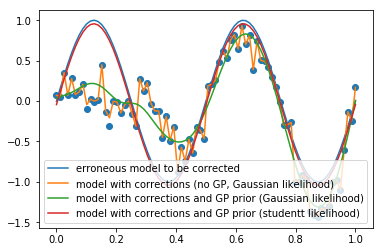

In [6]:
plt.scatter(xs, ys)
plt.plot(xs, ymod, label='erroneous model to be corrected')
plt.plot(xs, ymod + corrections_noGP, label='model with corrections (no GP, Gaussian likelihood)')
plt.plot(xs, ymod + corrections, label='model with corrections and GP prior (Gaussian likelihood)')
plt.plot(xs, ymod + corrections_studentt, label='model with corrections and GP prior (studentt likelihood)')
plt.legend()

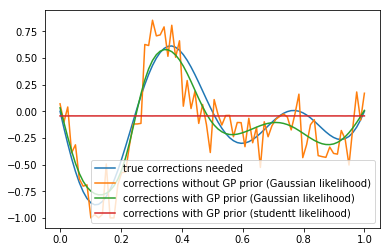

In [7]:
#plt.plot(xs, xs*0, c='k', ls='--')
plt.plot(xs, ymod_truth - ymod, label='true corrections needed')
plt.plot(xs, corrections_noGP, label='corrections without GP prior (Gaussian likelihood)')
plt.plot(xs, corrections, label='corrections with GP prior (Gaussian likelihood)')
plt.plot(xs, corrections_studentt, label='corrections with GP prior (studentt likelihood)')
plt.legend()